In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from moviepy import editor
import moviepy


In [2]:
"""
Region selection 
"""

def region_selection(image):
    #create array of same size as image
    mask = np.zeros_like(image)
    
    #if image with more then one channel
    if len(image.shape) > 2:
        channel_output = image.shape[2]
        ignore_mask_color = (255,) * channel_output
        
    # image with only one channel go under else
    else:
        ignore_mask_color = 255
    
    #creating a polygon to focus only on road
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]   
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

    #filling pixels inside the polygen white color and generating final mask
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [3]:
"""
 identifying straight line using Hough Transform
 image : grayscale image from edge detector
"""
def hough_transform(image):
    #distance resolution in pixels
    rho = 1
    # angle resulation in radians
    theta = np.pi/180
    #return line greater than threshold
    threshold = 20
    # line segments shorter than that are rejected
    minLineLength = 20
    # max allowed gap bet points on line
    maxLineGap = 500

    return cv2.HoughLinesP(image, rho=rho, theta=theta, threshold=threshold, 
                           minLineLength=minLineLength, maxLineGap=maxLineGap)

In [4]:
"""
find slope and intercept 
line : output from hough transform
"""
def average_slope_intercept(lines):
    left_lines = [] #(slope, intercept)
    left_weights = [] #(length, )
    right_lines = [] #(slope, intercept)
    right_weights = [] #(length,)

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            #calculating slope of line
            slope = (y2 - y1) / (x2 - x1)
            #calculating intercept of a line
            intercept = y1 - (slope*x1)
            #calculating length of line
            length = np.sqrt(((y2-y1)**2) + ((x2-x1)**2))

            #slope of left lane is negative and for right lane is positive
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))

    left_lane = np.dot(left_weights, left_lines) / np.sum(left_weights) if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    
    return left_lane, right_lane
    

In [5]:
"""
converts slope and intercept into pixel
y1 -y-value of line staring point
y2 -y-value of line end point
line slope and intercept of line
"""
def pixel_points(y1, y2, line):
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1-intercept)/slope)
    x2 = int((y2-intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1,y1),(x2,y2))

In [6]:
"""
create full length lines from pixel points
image - i/p test image
line - output of hough tranform
"""
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1*0.6
    left_line = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line

In [7]:
# draw lane lines

def draw_lane_lines(image, lines, color=[250, 0, 0], thickness=12):
    line_image = np.zeros_like(image)
    
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line, color, thickness) #red colour on lane lines
            
    left_line = lines[0]
    right_line = lines[1]
    points = np.array([
        left_line[0],  # bottom of left line
        left_line[1],  # top of left line
        right_line[1], # top of right line
        right_line[0]  # bottom of right line
    ])
    
    # Fill polygon with green color
    cv2.fillPoly(line_image, [points], (0, 255, 0))        
    return cv2.addWeighted(image, 1.0, line_image, 0.4, 0.0)


In [8]:
# convert to grayscale image
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Gaussian blur to remove noise from image
def gaussian_blur(image, kernel_size):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

# canny edge detection
def canny(image, low_threshold, high_threshold):
    return cv2.Canny(image, low_threshold, high_threshold)

#convert to BGR to RGB color
def rgb_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    

In [9]:
"""
input fame to detect lane lines
image - image of raod where wants to detect lane line
"""
def frame_processor(image):
    # convert to grayscale image
    gray_scale = grayscale(image)
    
    kernel_size = 5
    #applying gaussian blur to remove noise from image
    blur = gaussian_blur(gray_scale, kernel_size)
    
    # applying canny edge detection
    edges = canny(blur, 50, 150)
    
    #apply mask ploygon to only focus on road 
    region = region_selection(edges)
    
    #applying Hough transform to get straight lines from image
    hough = hough_transform(region)
    
    #draw lines in rsult frame
    result = draw_lane_lines(image, lane_lines(image, hough))
    return result

In [10]:
"""
Display input and output image
"""
def process_image(test_image):
    test_image = rgb_scale(test_image)
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(1, 2, 1,xticks=[], yticks=[])
    plt.imshow(test_image)
    ax.set_title("Input Image")
    ax = fig.add_subplot(1, 2, 2,xticks=[], yticks=[])
    plt.imshow(frame_processor(test_image))
    ax.set_title("Output Image [Lane Line Detected]")
    plt.show()
    
    

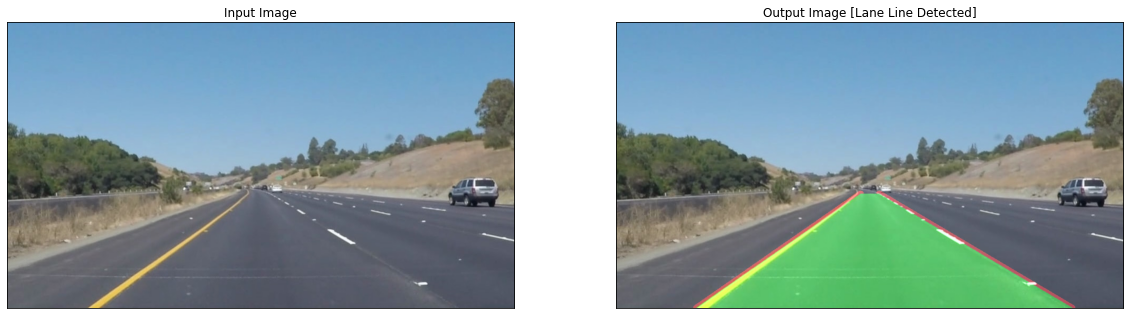

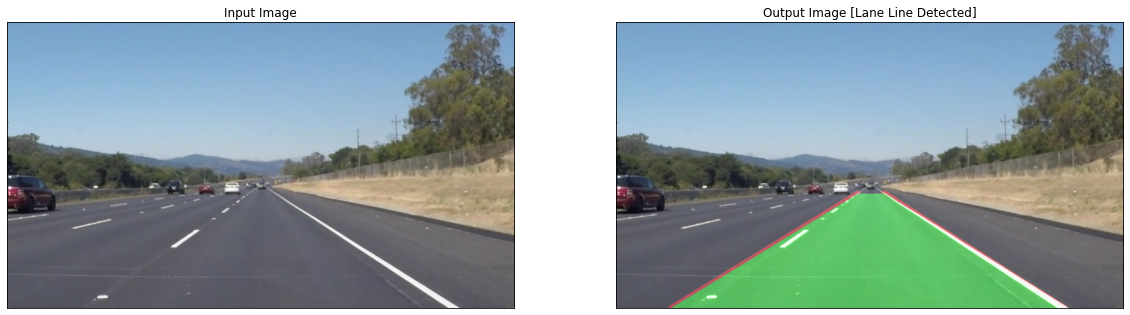

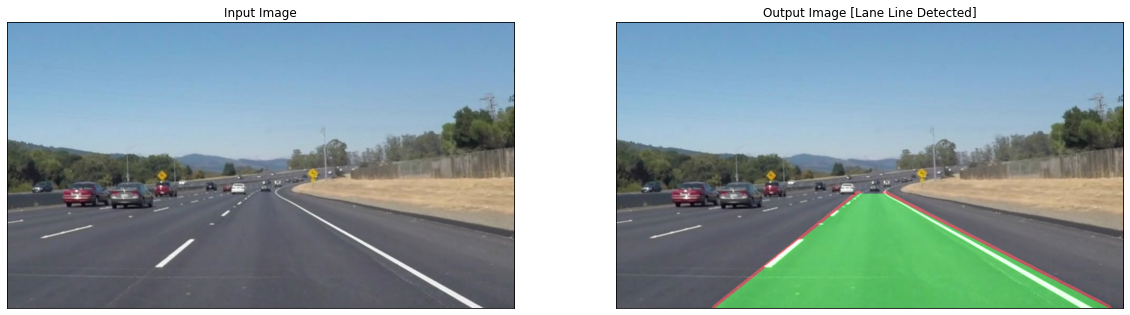

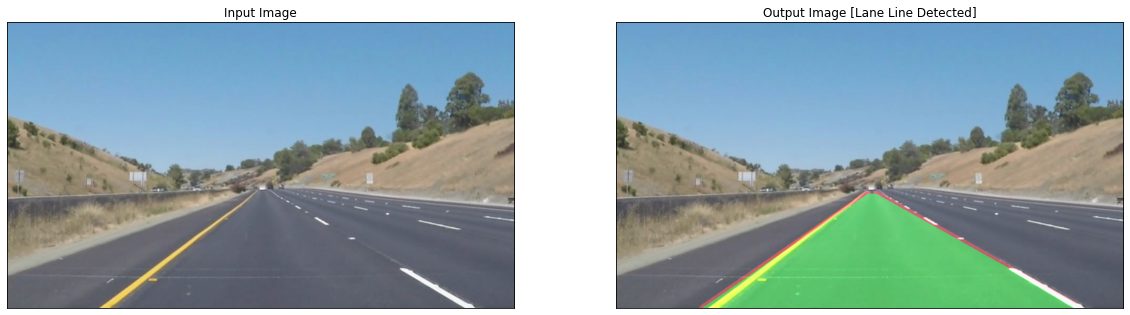

In [11]:
"""
Detect lines with different images
"""

image = []
image.append(cv2.imread('solidYellowCurve.jpg'))
image.append(cv2.imread('solidWhiteRight.jpg'))
image.append(cv2.imread('solidWhiteCurve.jpg'))
image.append(cv2.imread('whiteCarLaneSwitch.jpg'))
for i in image:
    process_image(i)

In [12]:
"""
read input video stream and produce a video file with detected lane lines
"""

#driver function
def process_video(test_video, output_video):
    #read input video
    input_video = editor.VideoFileClip(test_video, audio=False)
    
    # apply the function frame_processor to each frame of video
    processed = input_video.fl_image(frame_processor)
    #save the ouput video
    processed.write_videofile(output_video, audio=False)
    

In [13]:
#Test with video clip[with white Lane lines]

process_video("solidWhiteRight.mp4","output.mp4")

Moviepy - Building video output.mp4.
Moviepy - Writing video output.mp4



Moviepy - Done !
Moviepy - video ready output.mp4


In [14]:
from IPython.display import HTML

HTML("""
<video width="960" height="500" controls>
  <source src="{0}">
</video>
""".format('output.mp4'))

In [ ]:
#Test with video clip 2 [with yellow lane lines]
process_video("solidYellowLeft.mp4","output3.mp4")

Moviepy - Building video output3.mp4.
Moviepy - Writing video output3.mp4



Moviepy - Done !
Moviepy - video ready output3.mp4


In [ ]:

HTML("""
<video width="960" height="500" controls>
  <source src="{0}">
</video>
""".format('output3.mp4'))